In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

import yfinance as yf

# S&P 500 섹터 지수 심볼 리스트
symbols = [   
    "069500.KS", # KODEX 200
    "232080.KS", # Mirae Asset Tiger KOSDAQ150 ETF
    "143850.KS", # Mirae Asset TIGER S&P500 Futures ETF
    "195930.KS",# Mirae Asset TIGER Synth - Euro Stoxx 50 ETF H - Equity-Derivatives ()
    "238720.KS", #KINDEX Japan Nikkei225 ETF(H) ()
    "192090.KS", #Mirae Asset TIGER ChinaA300 ETF ()
    "148070.KS", #KOSEF 10yr KTB (148070.KS)
    "136340.KS", #KStar Credit Bond ETF (Bond)
    "182490.KS", #Mirae Asset TIGER Synth - iBoxx Short Term High Yield ETF H - Bonds-Derivatives ()
    "132030.KS", #Samsung KODEX Gold Futures Special Asset ETF - Gold-Derivatives (H) ()
    "130680.KS", #Mirae Asset TIGER WTI Futures ETF ()
    "114800.KS",#Samsung Kodex Inverse ETF - Equity-Derivatives ()
    "138230.KS", #KOSEF US Dollar ()
    "139660.KS",#KOSEF USD Inverse Futures ()
    "130730.KS",#KOSEF Enhanced Cash ()


    
]


# 데이터 다운로드
data = yf.download(symbols, start="1999-01-01", end="2024-08-01",interval='1wk')#interval='1wk'

[*********************100%%**********************]  15 of 15 completed


In [3]:
data['Adj Close'].columns

Index(['069500.KS', '114800.KS', '130680.KS', '130730.KS', '132030.KS',
       '136340.KS', '138230.KS', '139660.KS', '143850.KS', '148070.KS',
       '182490.KS', '192090.KS', '195930.KS', '232080.KS', '238720.KS'],
      dtype='object')

In [4]:
columns = ['KODEX 200','Kodex Inverse ETF','WTI Futures','Enhanced Cash','Gold Futures','KStar Credit Bond','US Dollar','USD Inverse Futures',
           'TIGER S&P500','KOSEF 10yr KTB','Short Term High Yield','ChinaA300','Euro Stoxx 50','KOSDAQ150','Japan Nikkei225']

In [5]:
daydata = data['Adj Close']
daydata.columns = columns
first_valid_index = daydata.dropna().index[0]
daydata = daydata.loc[first_valid_index:]

In [6]:
daydata.isna().sum().sum()

0

In [8]:
# daydata.interpolate(method='linear', inplace=True)
dayreturn = daydata.pct_change().dropna(axis = 0)
dayreturn['Cash Only'] = 0

In [9]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
previous_weights = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
# 자산군 이름
assets = ['KODEX 200','Kodex Inverse ETF','WTI Futures','Enhanced Cash','Gold Futures','KStar Credit Bond','US Dollar','USD Inverse Futures',
           'TIGER S&P500','KOSEF 10yr KTB','Short Term High Yield','ChinaA300','Euro Stoxx 50','KOSDAQ150','Japan Nikkei225','Cash Only']

# 최소 및 최대 비율 설정 (개별 자산)
min_weights = np.array([0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.01])
max_weights = np.array([0.40, 0.10, 0.15, 0.50, 0.15, 0.40, 0.20, 0.20, 0.20, 0.50, 0.40, 0.20, 0.20, 0.20, 0.20, 0.50])

# 그룹별 제약 조건 설정
groups = {
    '국내주식': ['KODEX 200', 'KOSDAQ150'],
    '해외주식': ['TIGER S&P500', 'Euro Stoxx 50', 'Japan Nikkei225', 'ChinaA300'],
    '채권': ['KOSEF 10yr KTB', 'KStar Credit Bond', 'Short Term High Yield'],
    '원자재': ['Gold Futures', 'WTI Futures'],
    'Inverse': ['Kodex Inverse ETF'],
    'FX': ['US Dollar', 'USD Inverse Futures'],
    '현금': ['Enhanced Cash', 'Cash Only']
}

group_constraints = {
    '국내주식': (0.10, 0.40),
    '해외주식': (0.10, 0.40),
    '채권': (0.20, 0.60),
    '원자재': (0.05, 0.20),
    'Inverse': (0.00, 0.20),
    'FX': (0.00, 0.20),
    '현금': (0.01, 0.50)
}

# 자산과 그룹 매핑
asset_to_group = {asset: group for group, assets in groups.items() for asset in assets}

# 무위험 이자율 설정 (예: 0.5% 연간 수익률을 주간 수익률로 변환)
risk_free_rate = 0.04 / 52

def group_constraint_lower(weights, indices, min_val):
    return np.sum(weights[indices]) - min_val

def group_constraint_upper(weights, indices, max_val):
    return max_val - np.sum(weights[indices])

def optimize_portfolio(returns, previous_weights):
    transaction_cost = 0.00015
    """ 주어진 수익률 데이터에 기반한 포트폴리오 가중치 최적화 """
    n_assets = returns.shape[1]
    init_guess = np.ones(n_assets) / n_assets
    bounds = [(min_weights[i], max_weights[i]) for i in range(n_assets)]
    
    constraints = [
        {'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
        {'type': 'ineq', 'fun': lambda x: np.sum(x) - 1}
    ] # 모든 가중치의 합은 1이어야 함

    # 그룹 제약 조건 추가
    for group, (min_val, max_val) in group_constraints.items():
        indices = [i for i, asset in enumerate(returns.columns) if asset in groups[group]]
        constraints.append({'type': 'ineq', 'fun': lambda x, idx=indices, min_val=min_val: group_constraint_lower(x, idx, min_val)})
        constraints.append({'type': 'ineq', 'fun': lambda x, idx=indices, max_val=max_val: group_constraint_upper(x, idx, max_val)})
    
    def objective(weights):
        # 포트폴리오 리스크(표준 편차)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
        # 포트폴리오 기대 수익률
        portfolio_return = np.dot(returns.mean(), weights)
        # 거래 비용 계산
        transaction_costs = transaction_cost * np.sum(np.maximum(0, previous_weights - weights))
        # 샤프 지수 계산 (부호를 반전하여 최소화 문제로 변환)
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
        # 부호를 반전하여 최소화 문제로 변환, 거래 비용 추가
        return -sharpe_ratio + transaction_costs

    result = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# 예제 데이터 생성

# 거래 비용 비율 (예: 0.1%

# 최적화 실행
optimal_weights = optimize_portfolio(dayreturn, previous_weights)

# 결과 출력
print("최적 포트폴리오 가중치:")
for asset, weight in zip(assets, optimal_weights):
    print(f"{asset}: {weight:.2%}")

최적 포트폴리오 가중치:
KODEX 200: 10.00%
Kodex Inverse ETF: 0.00%
WTI Futures: 0.00%
Enhanced Cash: 0.00%
Gold Futures: 9.00%
KStar Credit Bond: 5.69%
US Dollar: 20.00%
USD Inverse Futures: 0.00%
TIGER S&P500: 20.00%
KOSEF 10yr KTB: 0.00%
Short Term High Yield: 14.31%
ChinaA300: 0.00%
Euro Stoxx 50: 0.00%
KOSDAQ150: 0.00%
Japan Nikkei225: 20.00%
Cash Only: 1.00%


# MV basic

In [10]:
all_mv_value = []
all_mv_weight = []
for window in range(10,60,10):
    initial_investment = 100000
    portfolio_values = [initial_investment]
    weekly_returns = dayreturn
    weights_list_MV= []
    previous_weights = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    for i in range(60, len(weekly_returns) - 1):
        past_returns = weekly_returns.iloc[i-window//2:i]  # 지난 30주간의 수익률
        optimal_weights = optimize_portfolio(past_returns,previous_weights)
        weights_list_MV.append(optimal_weights)
        transaction_costs = 0.00015 * np.sum(np.maximum(0, previous_weights - optimal_weights))
        next_week_return = weekly_returns.iloc[i+1].dot(optimal_weights)

        new_value = portfolio_values[-1] * (1 + next_week_return) - transaction_costs * portfolio_values[-1]
        previous_weights = optimal_weights
        portfolio_values.append(new_value)
    all_mv_value.append(portfolio_values.copy())
    all_mv_weight.append(weights_list_MV)
    # 초기 값 1 (100% 원금)




/Users/sonhyeongjin/miniforge3/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/sonhyeongjin/miniforge3/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Users/sonhyeongjin/miniforge3/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:501: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


In [11]:
len(weights_list_MV[0])

16

In [12]:
returns = np.array(pd.DataFrame(portfolio_values).pct_change().dropna())
portfolio_return = []
cumulative_value = 1 
for r in returns:
    cumulative_value *= (1 + r)
    portfolio_return.append(cumulative_value.copy())

mv_pd = pd.DataFrame(weights_list_MV,index=dayreturn[61:].index,columns=assets)

In [13]:
pd.DataFrame(np.corrcoef(all_mv_value))

,0,1,2,3,4
0,1.000000,0.935878,0.955448,0.943627,0.949597
1,0.935878,1.000000,0.967419,0.950002,0.955286
2,0.955448,0.967419,1.000000,0.995126,0.994245
3,0.943627,0.950002,0.995126,1.000000,0.996002
4,0.949597,0.955286,0.994245,0.996002,1.000000


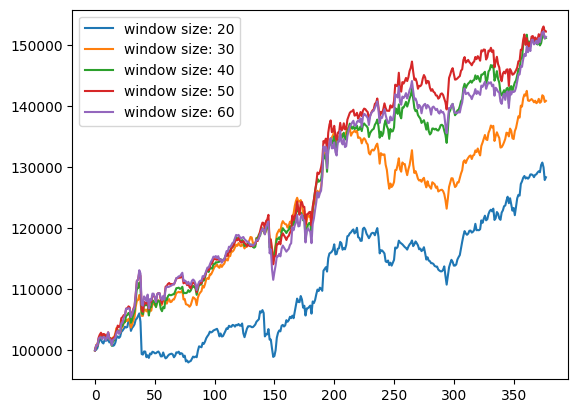

In [14]:
count = 0
for i in all_mv_value:
    plt.plot(i,label = f"window size: {(count+2)*10}")
    plt.legend()
    count += 1


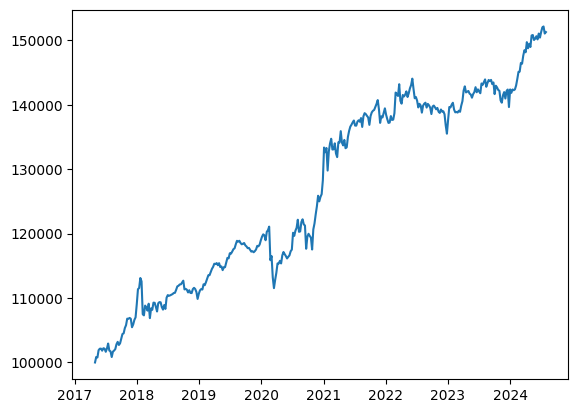

In [15]:
plt.plot(dayreturn[60:].index,portfolio_values)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


balance_series = pd.Series(portfolio_values)

# 최대 낙폭(MDD) 계산 함수
def max_drawdown(series):
    cumulative_max = series.cummax()
    drawdown = (series - cumulative_max) / cumulative_max
    return drawdown.min()

# 변동성 계산 함수
def volatility(series):
    daily_returns = series.pct_change().dropna()
    return daily_returns.std()

# VaR 계산 함수
def value_at_risk(series, confidence_level=0.95):
    daily_returns = series.pct_change().dropna()
    return np.percentile(daily_returns, 100 * (1 - confidence_level))

# ES 계산 함수
def expected_shortfall(series, confidence_level=0.95):
    daily_returns = series.pct_change().dropna()
    var = value_at_risk(series, confidence_level)
    return daily_returns[daily_returns <= var].mean()

# 샤프 비율 계산 함수
def sharpe_ratio(series, risk_free_rate=0.04):
    daily_returns = series.pct_change().dropna()
    excess_returns = daily_returns - risk_free_rate / 252
    return excess_returns.mean() / excess_returns.std() * np.sqrt(252)

# 견고성 지표 계산
mdd = max_drawdown(balance_series)
vol = volatility(balance_series)
var = value_at_risk(balance_series)
es = expected_shortfall(balance_series)
sharpe = sharpe_ratio(balance_series)

# 결과 출력
results = {
    "Max Drawdown": mdd,
    "Volatility": vol,
    "VaR (95%)": var,
    "Expected Shortfall (95%)": es,
    "Sharpe Ratio": sharpe
}

                             Value
Max Drawdown             -0.078836
Volatility                0.008261
VaR (95%)                -0.011216
Expected Shortfall (95%) -0.019882
Sharpe Ratio              1.871786


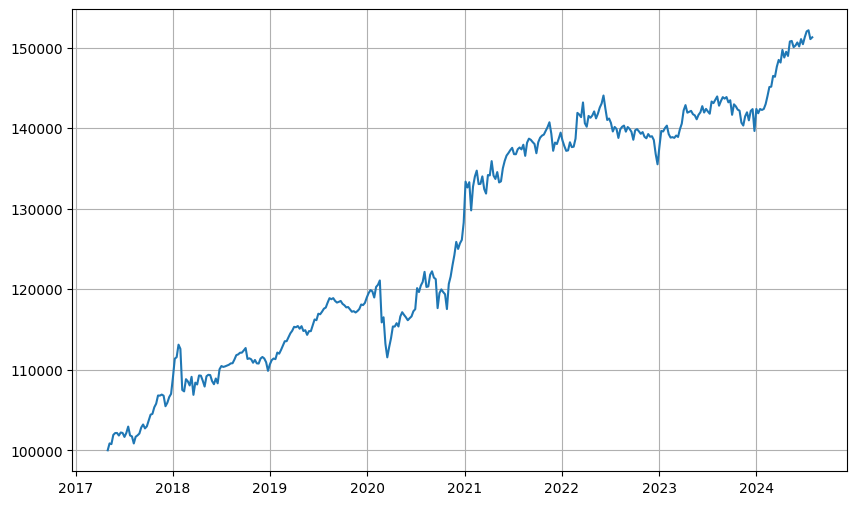

In [17]:
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

# 결과 출력
print(results_df)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(dayreturn.index[60:],balance_series.values)
plt.grid(True)
plt.show()

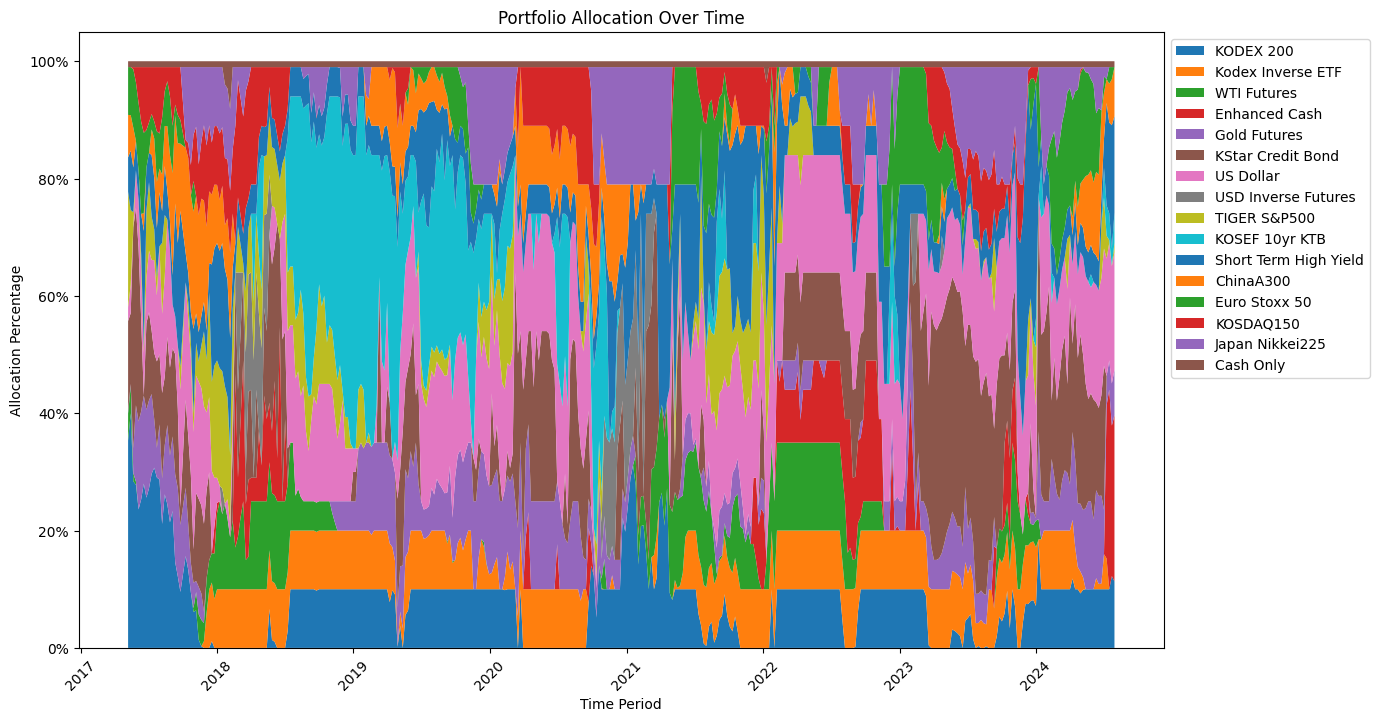

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


portfolio_df = mv_pd

# 시각화: 면적 그래프 (Stackplot) 생성
fig, ax = plt.subplots(figsize=(14, 8))
ax.stackplot(portfolio_df.index, portfolio_df.T, labels=portfolio_df.columns)
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
ax.set_title('Portfolio Allocation Over Time')
ax.set_xlabel('Time Period')
ax.set_ylabel('Allocation Percentage')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.xticks(rotation=45)
plt.show()